In [1]:
# Importing of necessary libraries
import pandas as pd
import streamlit as st
import seaborn as sns
import matplotlib.pyplot as plt


# Loading of Excel file
excel_file = pd.read_excel('data_source/Twisto_data.xlsx', sheet_name=None)

In [2]:
# Extracting of individual DataFrames
df_base = excel_file['profile_base']
df_customer = excel_file['profile_customer']
df_extension = excel_file['profile_extension']
df_apps = excel_file['profile_apps']
df_transactions = excel_file['profile_transactions']

In [3]:
# Filling in all empty values in df_transaction (column: category)

df_transactions['category'] = df_transactions['category'].fillna('Unknown')

In [4]:
def classify_os(row):
    ios = row['app_ios'] > 0
    android = row['app_android'] > 0
    
    if ios:
        return 'iOS'
    elif android:
        return 'Android'
    elif ios and android:
        return 'Both'
    else:
        return 'Unknown'

# Create new column 'os_type'
df_apps['os_type'] = df_apps.apply(classify_os, axis=1)

# Count unique users by os_type
os_counts = df_apps.groupby('os_type')['user'].nunique()

print(os_counts)

os_type
Android    281
Unknown    427
iOS        292
Name: user, dtype: int64


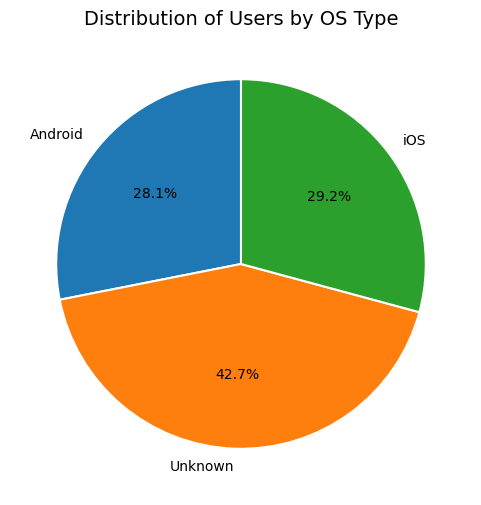

In [11]:
%matplotlib inline
plt.figure(figsize=(6,6))
plt.pie(
    os_counts, 
    labels=os_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
)
plt.title("Distribution of Users by OS Type", fontsize=14)
plt.show()

In [12]:
# Merging of df_apps and df_transactions
df_trans_platform = df_transactions.merge(df_apps[['user', 'os_type']], on='user', how='left')

In [13]:
df_trans_platform

,category,merchant,date_created,id,total_price_vat,transaction_source,user,os_type
0,Unknown,Twisto Snap,2016-11-02 09:15:17.975,295939,3930.0,Snap,0.000002,Unknown
1,Unknown,Twisto Snap,2016-09-20 09:35:10.649,262629,70.0,Snap,0.000002,Unknown
2,Unknown,Twisto Snap,2016-09-20 09:27:01.354,262622,210.0,Snap,0.000002,Unknown
3,sluzby,ticketportal.cz,2019-07-13 18:11:44.574,3723225,790.0,Now,0.000002,Unknown
4,sluzby,ticketportal.cz,2019-04-06 21:39:16.069,2820936,1980.0,Now,0.000002,Unknown
...,...,...,...,...,...,...,...,...
67262,slevovy-portal,Slevomat.cz,2017-02-28 18:51:35.370,407848,188.0,Now,0.012364,Android
67263,slevovy-portal,Slevomat.cz,2016-06-28 19:23:19.703,208229,289.0,Now,0.012364,Android
67264,slevovy-portal,Pepa.cz,2017-05-21 09:04:10.979,477682,199.0,Now,0.012364,Android
67265,obchodni-dum,tescoma.cz,2019-11-03 12:57:13.428,5091987,338.0,Now,0.012364,Android


In [14]:
# Number of transactions per user by platform
trans_per_user = (
    df_trans_platform.groupby(['os_type', 'user'])
    .size()
    .reset_index(name='num_transactions')
)

# Average number of transactions per user by platform
avg_trans_per_platform = trans_per_user.groupby('os_type')['num_transactions'].mean()

print("Average transactions per user by platform:\n", avg_trans_per_platform)

# Sum and average of total_price_vat (amount)

if 'total_price_vat' in df_transactions.columns:
    amount_stats = (
        df_trans_platform.groupby('os_type')['total_price_vat']
        .agg(['sum', 'mean'])
    )
    print("\nTransaction amount stats by platform:\n", amount_stats)

Average transactions per user by platform:
 os_type
Android     92.762846
Unknown     29.151235
iOS        139.646341
Name: num_transactions, dtype: float64

Transaction amount stats by platform:
                  sum        mean
os_type                         
Android  16742698.90  713.396348
Unknown   5766721.58  610.558134
iOS      15502775.01  451.278637


In [15]:
category_counts = (
    df_trans_platform.groupby(['os_type', 'category'])
    .size()
    .unstack(fill_value=0)
)

print("\nTransaction counts by category and platform:\n", category_counts)


Transaction counts by category and platform:
 category  Beauty  Bills And Household   Car  Children  Culture  \
os_type                                                          
Android       63                   28  1089        64      104   
Unknown        6                    4   352        12       21   
iOS          118                   30  2976        99      177   

category  Digital Services  Drugstore  Electronics  Fashion  \
os_type                                                       
Android                756        379           81      497   
Unknown                 86        101           13      111   
iOS                    971        625          224      674   

category  Financial Services  ...  kancelar  knihy  moda  obchodni-dum  \
os_type                       ...                                        
Android                   55  ...         3     65   260            30   
Unknown                    4  ...         5    157   276            25   
iOS       

In [16]:
# Top 10 categories by revenue
top10_revenue = (
    df_transactions.groupby('category')['total_price_vat']
    .sum()
    .sort_values(ascending=False)
    .head(9)
    .index
)

# Top 10 categories by transaction count
top10_count = (
    df_transactions['category']
    .value_counts()
    .head(9)
    .index
)

# Union of both sets so we cover both
top_categories = set(top10_revenue).union(set(top10_count))

In [17]:
top_categories

{'Car',
 'Digital Services',
 'Fashion',
 'Food And Drink',
 'Groceries',
 'Shopping Online',
 'Travel',
 'Unknown',
 'potraviny',
 'slevovy-portal'}

In [18]:
# Assume df_apps has app_ios and app_android
def get_platform(row):
    if row['app_ios'] > 0:
        return 'iOS'
    elif row['app_android'] > 0:
        return 'Android'
    else:
        return 'Unknown'

df_apps['platform'] = df_apps.apply(get_platform, axis=1)

# Merge into transactions
df_trans_platform = df_transactions.merge(
    df_apps[['user', 'platform']], 
    on='user', 
    how='left'
)

In [19]:
df_top = df_trans_platform[df_trans_platform['category'].isin(top_categories)]

In [20]:
category_stats = (
    df_top.groupby(['platform', 'category'])
    .agg(
        total_revenue=('total_price_vat', 'sum'),
        transaction_count=('total_price_vat', 'count'),
        avg_transaction_value=('total_price_vat', 'mean')
    )
    .reset_index()
)

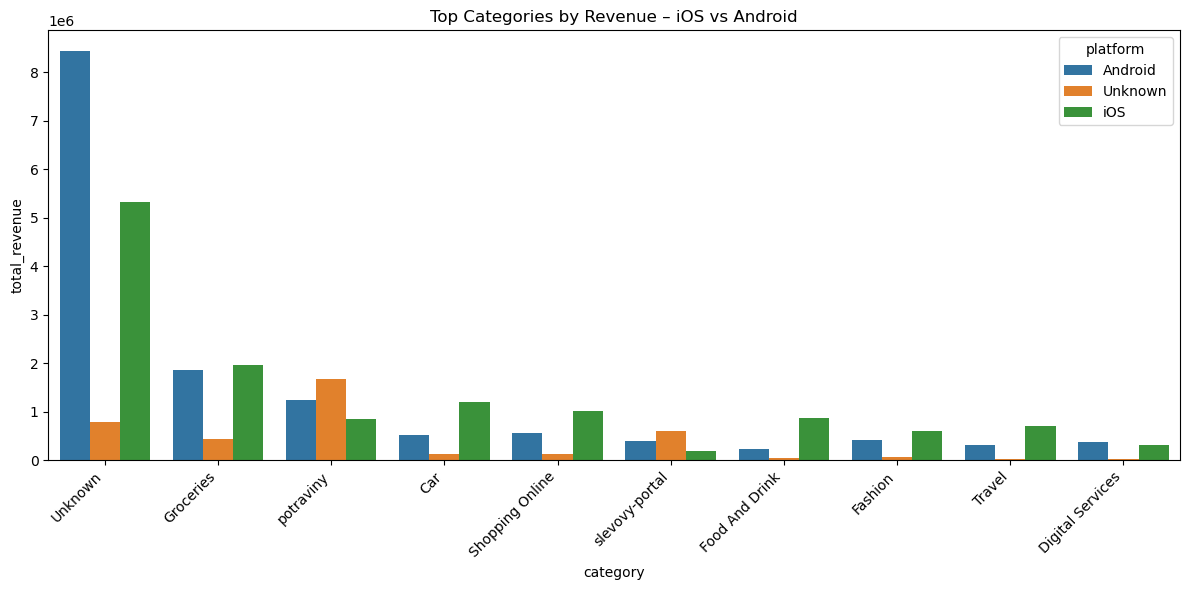

In [21]:
%matplotlib inline
# Sort by revenue in all platforms combined
order = (
    category_stats.groupby('category')['total_revenue']
    .sum()
    .sort_values(ascending=False)
    .index
)

plt.figure(figsize=(12,6))
sns.barplot(
    data=category_stats,
    x='category', 
    y='total_revenue', 
    hue='platform',
    order=order
)
plt.xticks(rotation=45, ha='right')
plt.title('Top Categories by Revenue – iOS vs Android')
plt.tight_layout()
plt.show()

In [24]:
df_trans_platform

,category,merchant,date_created,id,total_price_vat,transaction_source,user,platform
0,Unknown,Twisto Snap,2016-11-02 09:15:17.975,295939,3930.0,Snap,0.000002,Unknown
1,Unknown,Twisto Snap,2016-09-20 09:35:10.649,262629,70.0,Snap,0.000002,Unknown
2,Unknown,Twisto Snap,2016-09-20 09:27:01.354,262622,210.0,Snap,0.000002,Unknown
3,sluzby,ticketportal.cz,2019-07-13 18:11:44.574,3723225,790.0,Now,0.000002,Unknown
4,sluzby,ticketportal.cz,2019-04-06 21:39:16.069,2820936,1980.0,Now,0.000002,Unknown
...,...,...,...,...,...,...,...,...
67262,slevovy-portal,Slevomat.cz,2017-02-28 18:51:35.370,407848,188.0,Now,0.012364,Android
67263,slevovy-portal,Slevomat.cz,2016-06-28 19:23:19.703,208229,289.0,Now,0.012364,Android
67264,slevovy-portal,Pepa.cz,2017-05-21 09:04:10.979,477682,199.0,Now,0.012364,Android
67265,obchodni-dum,tescoma.cz,2019-11-03 12:57:13.428,5091987,338.0,Now,0.012364,Android


In [25]:
# 1. Number of transactions per OS
transactions_per_os = df_trans_platform.groupby('platform')['id'].count()

# 2. Average transaction value (AOV) per OS
avg_order_value = df_trans_platform.groupby('platform')['total_price_vat'].mean()

# 3. Total spending per user (group by user first, then aggregate by OS)
user_spending = df_trans_platform.groupby(['user', 'platform'])['total_price_vat'].sum().reset_index()
avg_spending_per_user = user_spending.groupby('platform')['total_price_vat'].mean()

# 4. Top categories by OS
category_distribution = df_trans_platform.groupby(['platform', 'category'])['id'].count().reset_index()
category_distribution = category_distribution.sort_values(['platform','id'], ascending=[True, False])

# 5. Top merchants by OS
merchant_distribution = df_trans_platform.groupby(['platform', 'merchant'])['id'].count().reset_index()
merchant_distribution = merchant_distribution.sort_values(['platform','id'], ascending=[True, False])

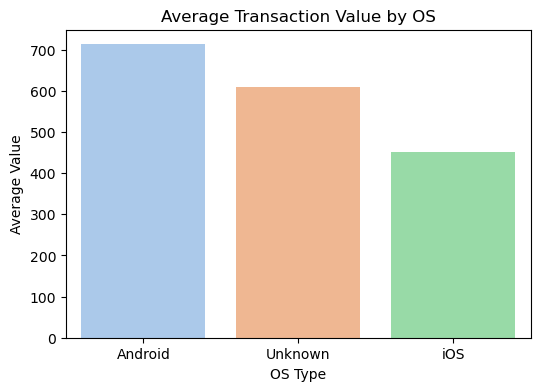

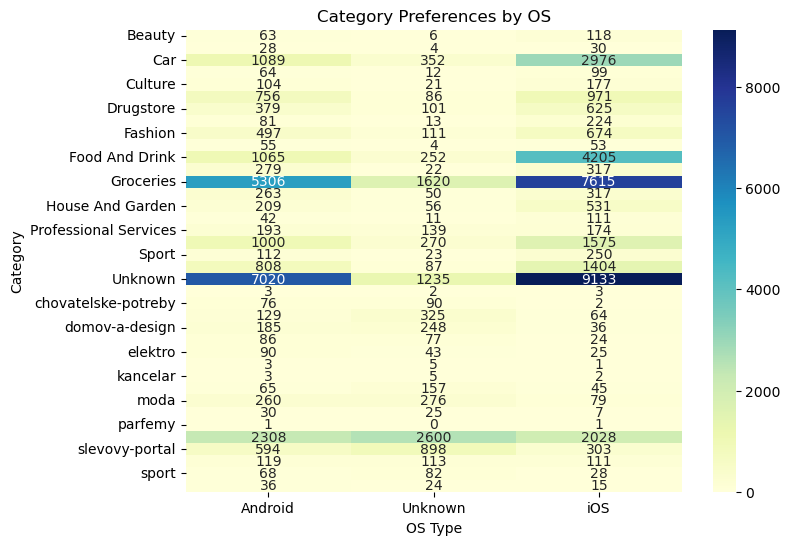

In [32]:
# Compare average transaction value
plt.figure(figsize=(6,4))
sns.barplot(
    data=avg_order_value.reset_index(),
    x="platform",
    y="total_price_vat",
    hue="platform",              # tell seaborn to color by os_type
    palette="pastel",
    legend=False                # don’t show duplicate legend
)
plt.title("Average Transaction Value by OS")
plt.ylabel("Average Value")
plt.xlabel("OS Type")
plt.show()


# Category preferences heatmap
pivot_cat = df_trans_platform.pivot_table(
    index='category',
    columns='platform',   # <-- fix here
    values='id',
    aggfunc='count',
    fill_value=0
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot_cat, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Category Preferences by OS")
plt.ylabel("Category")
plt.xlabel("OS Type")
plt.show()